In [0]:
#First, load file with stock prices.
#For Brazilian securities, you can find this file in https://github.com/felbuch/B3_daily_historical_data.
import pandas as pd
file = pd.read_parquet('B3.gzip')

In [0]:
class SupportResistance():

  '''Estimates support and resistance values for a stock
  
  Example of use:
  To estimate support and resistance values fro PETR4 in 2020:

  >>> sr = SupportResistance('PETR4', 2020) #Creates the instance
  >>> sr.get_data() #Loads the data. You may need to pass it the file name.
  >>> sr.fit() #Estimates support and resistance
  >>> sr.plot_price() #Plots the price history, with supports and resistances marked.

  You may also obtain the histogram of previous prices, 
  alongside the estimated probability density function with supports and resistances marked
  by running

  >>> sr.plot_pdf()

  This plot can help you identify if any support or resistance level has been missed.
  If it has, try reducing the value of the min_prominence parameter.
  
  Lower values of min_prominence mean we are more sensitive to local concentrations around prices 
  and are more eager to call these prices support or resistances.
  Higher levels means we are less sensitive to such concentrations and require
  that a price level is much more often visited than other price levels
  in order to call it a support or a resistance.

  If you want to obtain the values of estimates support and resistances in a Pandas dataframe,
  just run

  >>> my_dataframe = sr.data_frame()

  This returns a dataframe called my_dataframe that has a column of prices
  that are support/resistances  and a column of their strengths.
  Please see the function's documentation for an explanation on what strengths are.

  To see the estimator used (the best selector acording to the cv search
  performed in the .fit method), just access the attribute .estimator:

  >>> sr.estimator

  '''

  def __init__(self, stock, year):

    self.stock = stock
    self.year = year
    self.data = None
    self.estimator = None
    self.pdf = None
    self.xx_ = None
    self.support_resistances = None
    self.strengths = None

  
  def get_data(self, file = file):
    '''Imports B3 dataset from https://github.com/felbuch/B3_daily_historical_data
    and filters by year and stock of interest. 
    Here, 'file' should be the variable containing this file, previously imported.
    Also, creates array of prices to be used in the fitting process'''
    
    import pandas as pd
    import datetime as dt
    import numpy as np
    
    #Filter stock and year
    data = file.loc[(file.date.dt.year == self.year) & (file.security == self.stock), ['date','open','close']]

    #Transform open and close prices from cents to Brazilian Reais
    data['open'] = data['open']/100
    data['close'] = data['close']/100
    

    #Stack open and close prices, since both determine support and resistances
    #Reshape so it becomes 1D numpy array
    prices = np.vstack([data['open'],data['close']]).reshape(-1,1)

    #Save data and prices in self
    self.data = data
    self.prices = prices

  def fit(self, min_bandwidth_log = -1, max_bandwidth_log = 1, min_prominence = 0.01):
    ''' Finds the points of support and resistance.
    This is done in the following steps:
    (1) Estimate the probability density function of previous prices.
    The bindwidth and the kernel are determined by Grid Search cross-validation.
    We try both a gaussian kernel and an exponential kernel,
    to account for leptokurtosis in stock returns.
    Bin values range from 10**min_bandwidth_log to 100**max_bandwidth_log
    Since my object of interest is the distribution of prices, and not the time series itself,
    I do not use a time series cross-validation, but rather an ordinary 5-fold cross-validation.

    (2) Identify the peaks in the estimated density function. 
    To aviod inflexion points and minor peaks being counted, only peaks with a prominence higher than
    min_prominence are considered. 
    '''

    import numpy as np
    from sklearn.neighbors import KernelDensity
    from sklearn.model_selection import GridSearchCV
    from scipy.signal import find_peaks

    #Define values of bandwidths to try (hyperparameter space)
    bandwidths = 10 ** np.linspace(-1, 1, 100)
      
    #Grid search
    grid = GridSearchCV(KernelDensity(),
                        {'kernel': ['gaussian', 'exponential'],
                         'bandwidth': bandwidths})
    grid.fit(self.prices)
    best_estimator = grid.best_estimator_

    #Fit best estimator to data
    kde = best_estimator.fit(self.prices)

    #Construct pdf
    a, b = min(self.prices), max(self.prices)
    xx = np.linspace(a, b, 1000).reshape(-1,1)
    pdf = np.exp(kde.score_samples(xx))

    #Find maxima
    #These are the support and resistances
    peaks, _ = find_peaks(pdf, prominence = min_prominence)
    support_resistances = xx[peaks] #price values
    strengths = pdf[peaks] #density (related to strength of resistance/support)

    #Save to self
    self.estimator = best_estimator
    self.xx_ = xx
    self.pdf = pdf
    self.support_resistances = support_resistances
    self.strengths = strengths

  def data_frame(self):
    '''Returns a dataframe with values for the supports and resistances
    alongside their strengths.
    
    Note: The strength is merely the estimated value of the pdf at that price.
    A high value of strength means a stock has visited that price many times.
    Whether this means the support/resistance is stronger or weaker is up to you to decide :) 
    '''

    import pandas as pd

    output = pd.DataFrame({'price': self.support_resistances.reshape(-1,), 
                           'strength': self.strengths.reshape(-1,)})
    return(output)


  def plot_pdf(self, figsize = (10,6)):

    '''Plots the histogram of prices, with the probability density function
    estimated in the fit function. The maxima (i.e. points of support and resistance)
    are also shown.'''

    import matplotlib.pyplot as plt

    plt.figure(figsize=figsize)
    
    plt.hist(self.prices, density=True, bins=50, color= 'lightblue', alpha=0.4)
    plt.plot(self.xx_, self.pdf, linestyle='--', color='red')
    plt.scatter(self.support_resistances, self.strengths, color = 'blue')
    
    plt.title(f'Support and resistances in price distribution\n(stock: {self.stock})')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    
    plt.xticks(list(range(int(min(self.xx_)), int(max(self.xx_)))))
    plt.grid('on')
    plt.show()

  def plot_price(self, figsize = (10,6)):

    '''Plots the time series of price evolution (orange), 
    together with the estimated values of supports and resistances (blue)'''
    
    import matplotlib.pyplot as plt

    plt.figure(figsize=figsize)
    
    plt.title(f'Automatic detection of support and resistances in {self.stock} stock price ')
    plt.plot(self.data['date'] , self.data['close'], color = 'orange')
    
    for value in self.support_resistances:
      plt.axhline(y = value, linestyle = '--', color = 'blue', alpha = 0.8)

    plt.yticks(self.support_resistances)  
    plt.show()



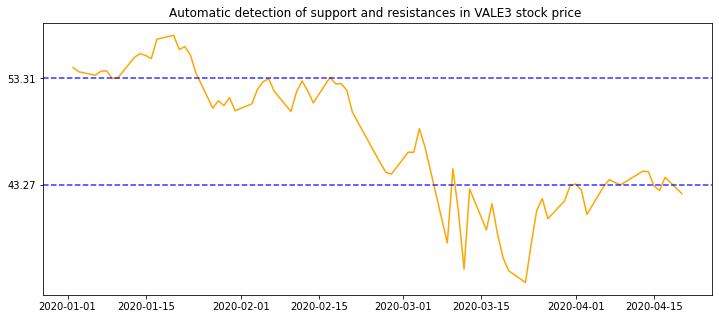

In [28]:
#An example
#Let's estimate the support and resistance for PETR4 in 2020
sr = SupportResistance('VALE3', 2020)
sr.get_data()
sr.fit()
sr.plot_price(figsize=(12,5))


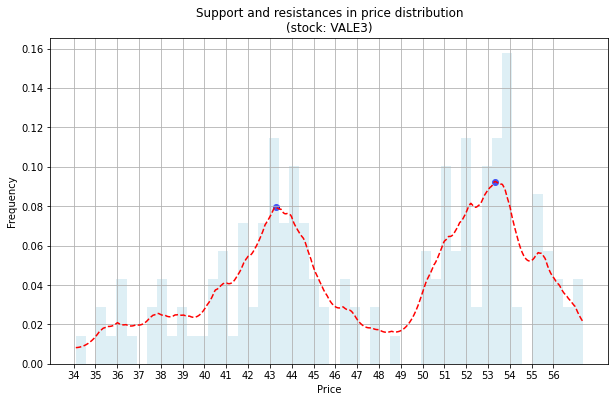

In [29]:
#Now let's take a look at the pdf of prices and where the support and resistances lie
sr.plot_pdf()

In [30]:
#We can also get it as a dataframe:
sr.data_frame()

,price,strength
0,43.273614,0.079434
1,53.308709,0.092502


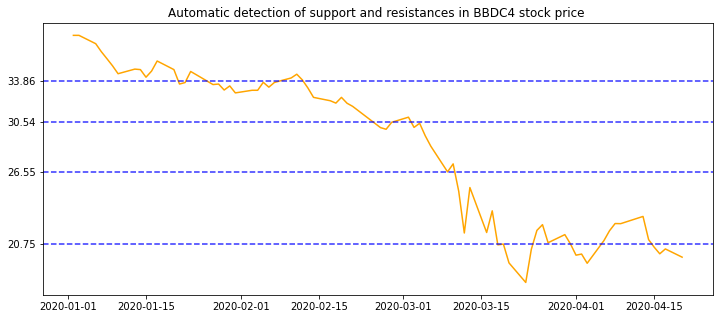

In [50]:
sr = SupportResistance('BBDC4', 2020)
sr.get_data()
sr.fit()
sr.plot_price(figsize=(12,5))

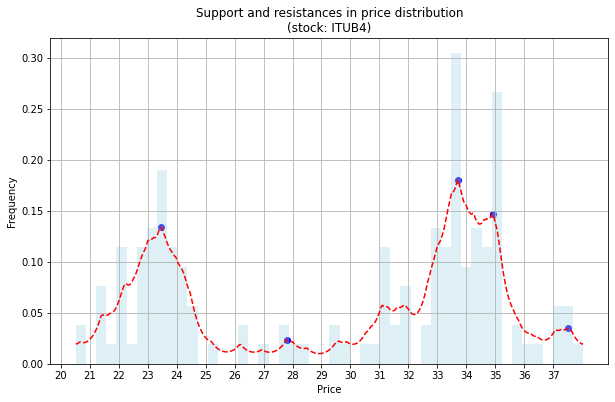

In [43]:
sr.plot_pdf()

In [19]:
sr.estimator

KernelDensity(algorithm='auto', atol=0, bandwidth=0.8497534359086445,
              breadth_first=True, kernel='exponential', leaf_size=40,
              metric='euclidean', metric_params=None, rtol=0)